<a href="https://colab.research.google.com/github/davisidarta/topometry/blob/master/TopOMetry_Intro_pbmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing PBMCs single-cell data with TopOMetry


For the manuscript

In [4]:
# Install pre-requisites and dbmap (for comparisons)
!pip install nmslib annoy scipy scanpy numba kneed pymde python-igraph leidenalg dbmap

     |████████████████████████████████| 10.3MB 5.8MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 133kB 42.9MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=55829444be1653c836701437efd20a5a6dc217ac4f2ca467ef22949203ec5883
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for sinfo: filename=sinfo-0.3.1-cp37-none-any.whl size=7012 sha256=fc125010cf50118d30d74875a19493781397de2456036969a37c6183fb1a202f
  Stored in directory: /root/.cache/pip/wheels/11/f0/23/347d6d8e59787c2bc272162d18223dc3b45bd6dc40aceee6af
Successfully built umap-learn sinfo


In [2]:
# Install pre-release of TopOMetry
!pip install -i https://test.pypi.org/simple/ topo

Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 102kB 4.1MB/s 


In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import dbmap as dm
import topo as tp

None
None


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, dpi_save=800, facecolor='white', format='tif')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.9.1


## Analyzing _pbmc10k_

### Load data and QC

In [11]:
!mkdir data
!wget https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_Human_PBMC_10K_PBMCs_human_1/SC3_v3_NextGem_DI_CellPlex_Human_PBMC_10K_PBMCs_human_1_count_sample_feature_bc_matrix.h5 -O data/SC3_v3_NextGem_DI_CellPlex_Human_PBMC_10K_PBMCs_human_1_count_sample_feature_bc_matrix.h5
!mkdir write

--2021-04-18 01:00:01--  https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_Human_PBMC_10K_PBMCs_human_1/SC3_v3_NextGem_DI_CellPlex_Human_PBMC_10K_PBMCs_human_1_count_sample_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15239045 (15M) [binary/octet-stream]
Saving to: ‘data/SC3_v3_NextGem_DI_CellPlex_Human_PBMC_10K_PBMCs_human_1_count_sample_feature_bc_matrix.h5’

data/SC3_v3_NextGem 100%[===================>]  14.53M  19.1MB/s    in 0.8s    

2021-04-18 01:00:02 (19.1 MB/s) - ‘data/SC3_v3_NextGem_DI_CellPlex_Human_PBMC_10K_PBMCs_human_1_count_sample_feature_bc_matrix.h5’ saved [15239045/15239045]



In [12]:
results_file = 'write/pbmc10k.h5ad'  # the file that will store the analysis results

In [16]:
adata = sc.read_10x_h5(
    'data/SC3_v3_NextGem_DI_CellPlex_Human_PBMC_10K_PBMCs_human_1_count_sample_feature_bc_matrix.h5')        
adata.var_names_make_unique()
adata                    

reading data/SC3_v3_NextGem_DI_CellPlex_Human_PBMC_10K_PBMCs_human_1_count_sample_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 6437 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [17]:
# Default QC
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata

filtered out 13 cells that have less than 200 genes expressed
filtered out 17855 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 6424 × 18746
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Default workflow

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=8, min_disp=0.3)
sc.pl.highly_variable_genes(adata)

In [19]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 6424 × 3513
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


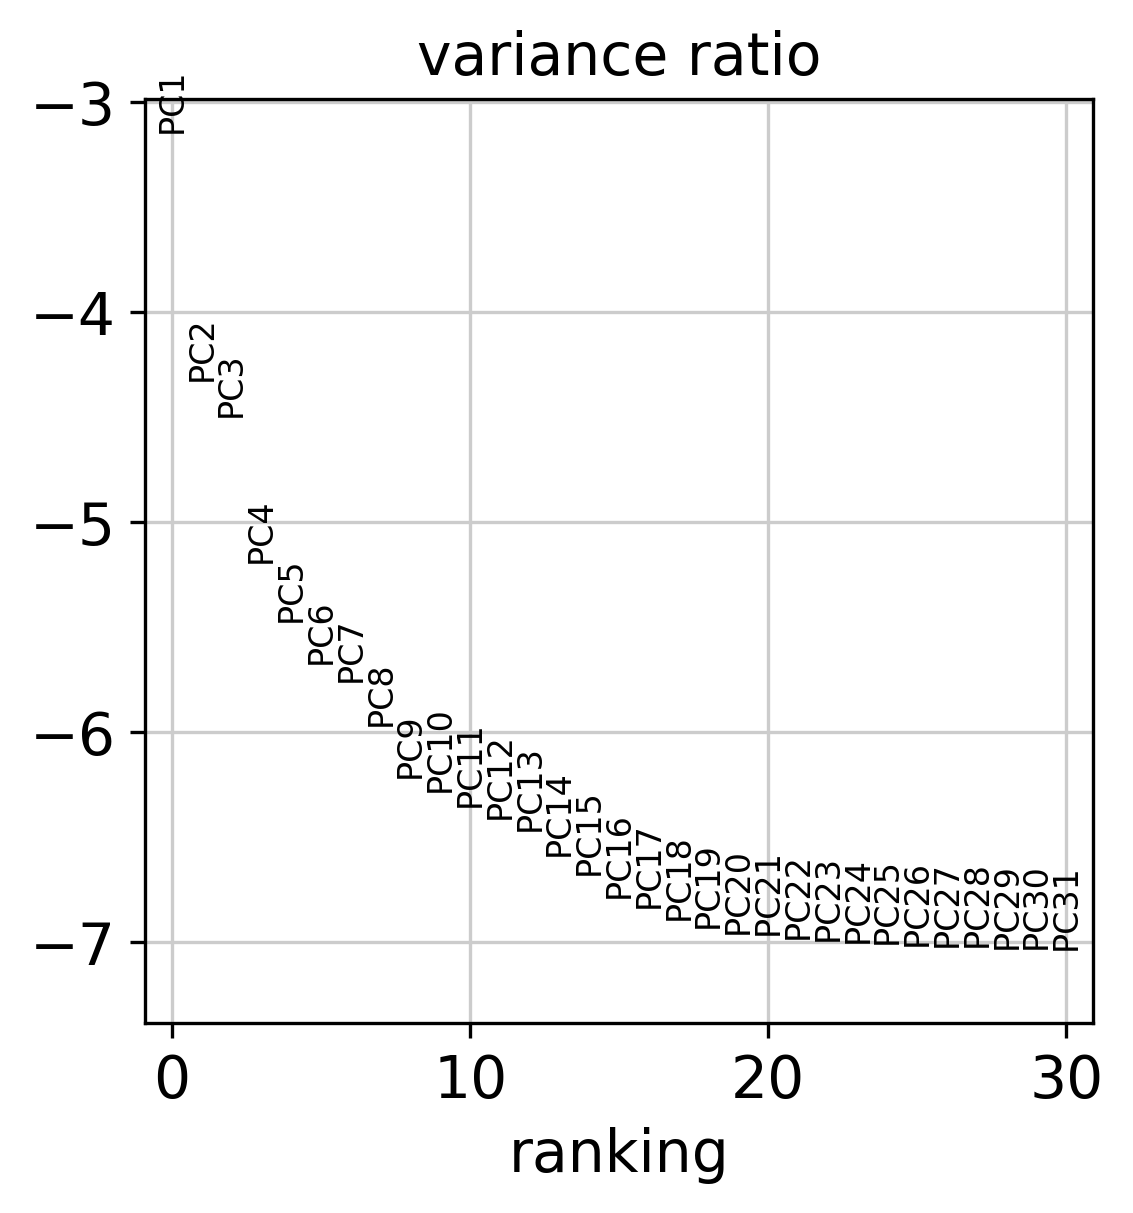

In [20]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True, save='_PCA_log_variance_ratio')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


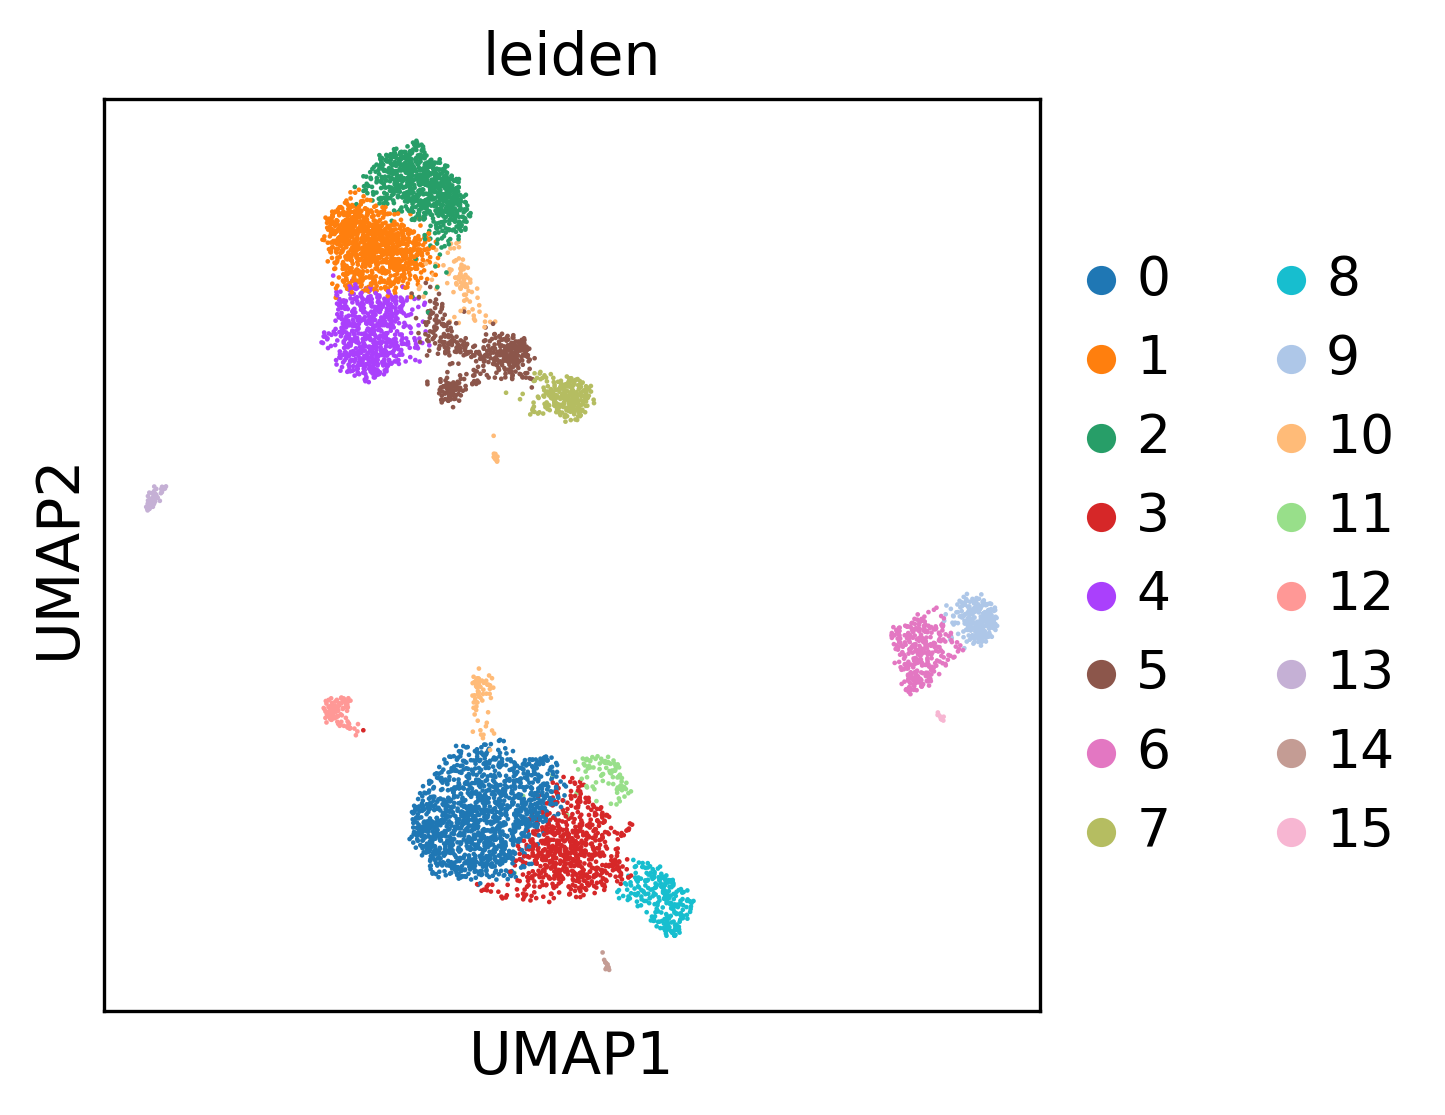

In [31]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.embedding(adata, basis='umap', color=['leiden'], size=5)

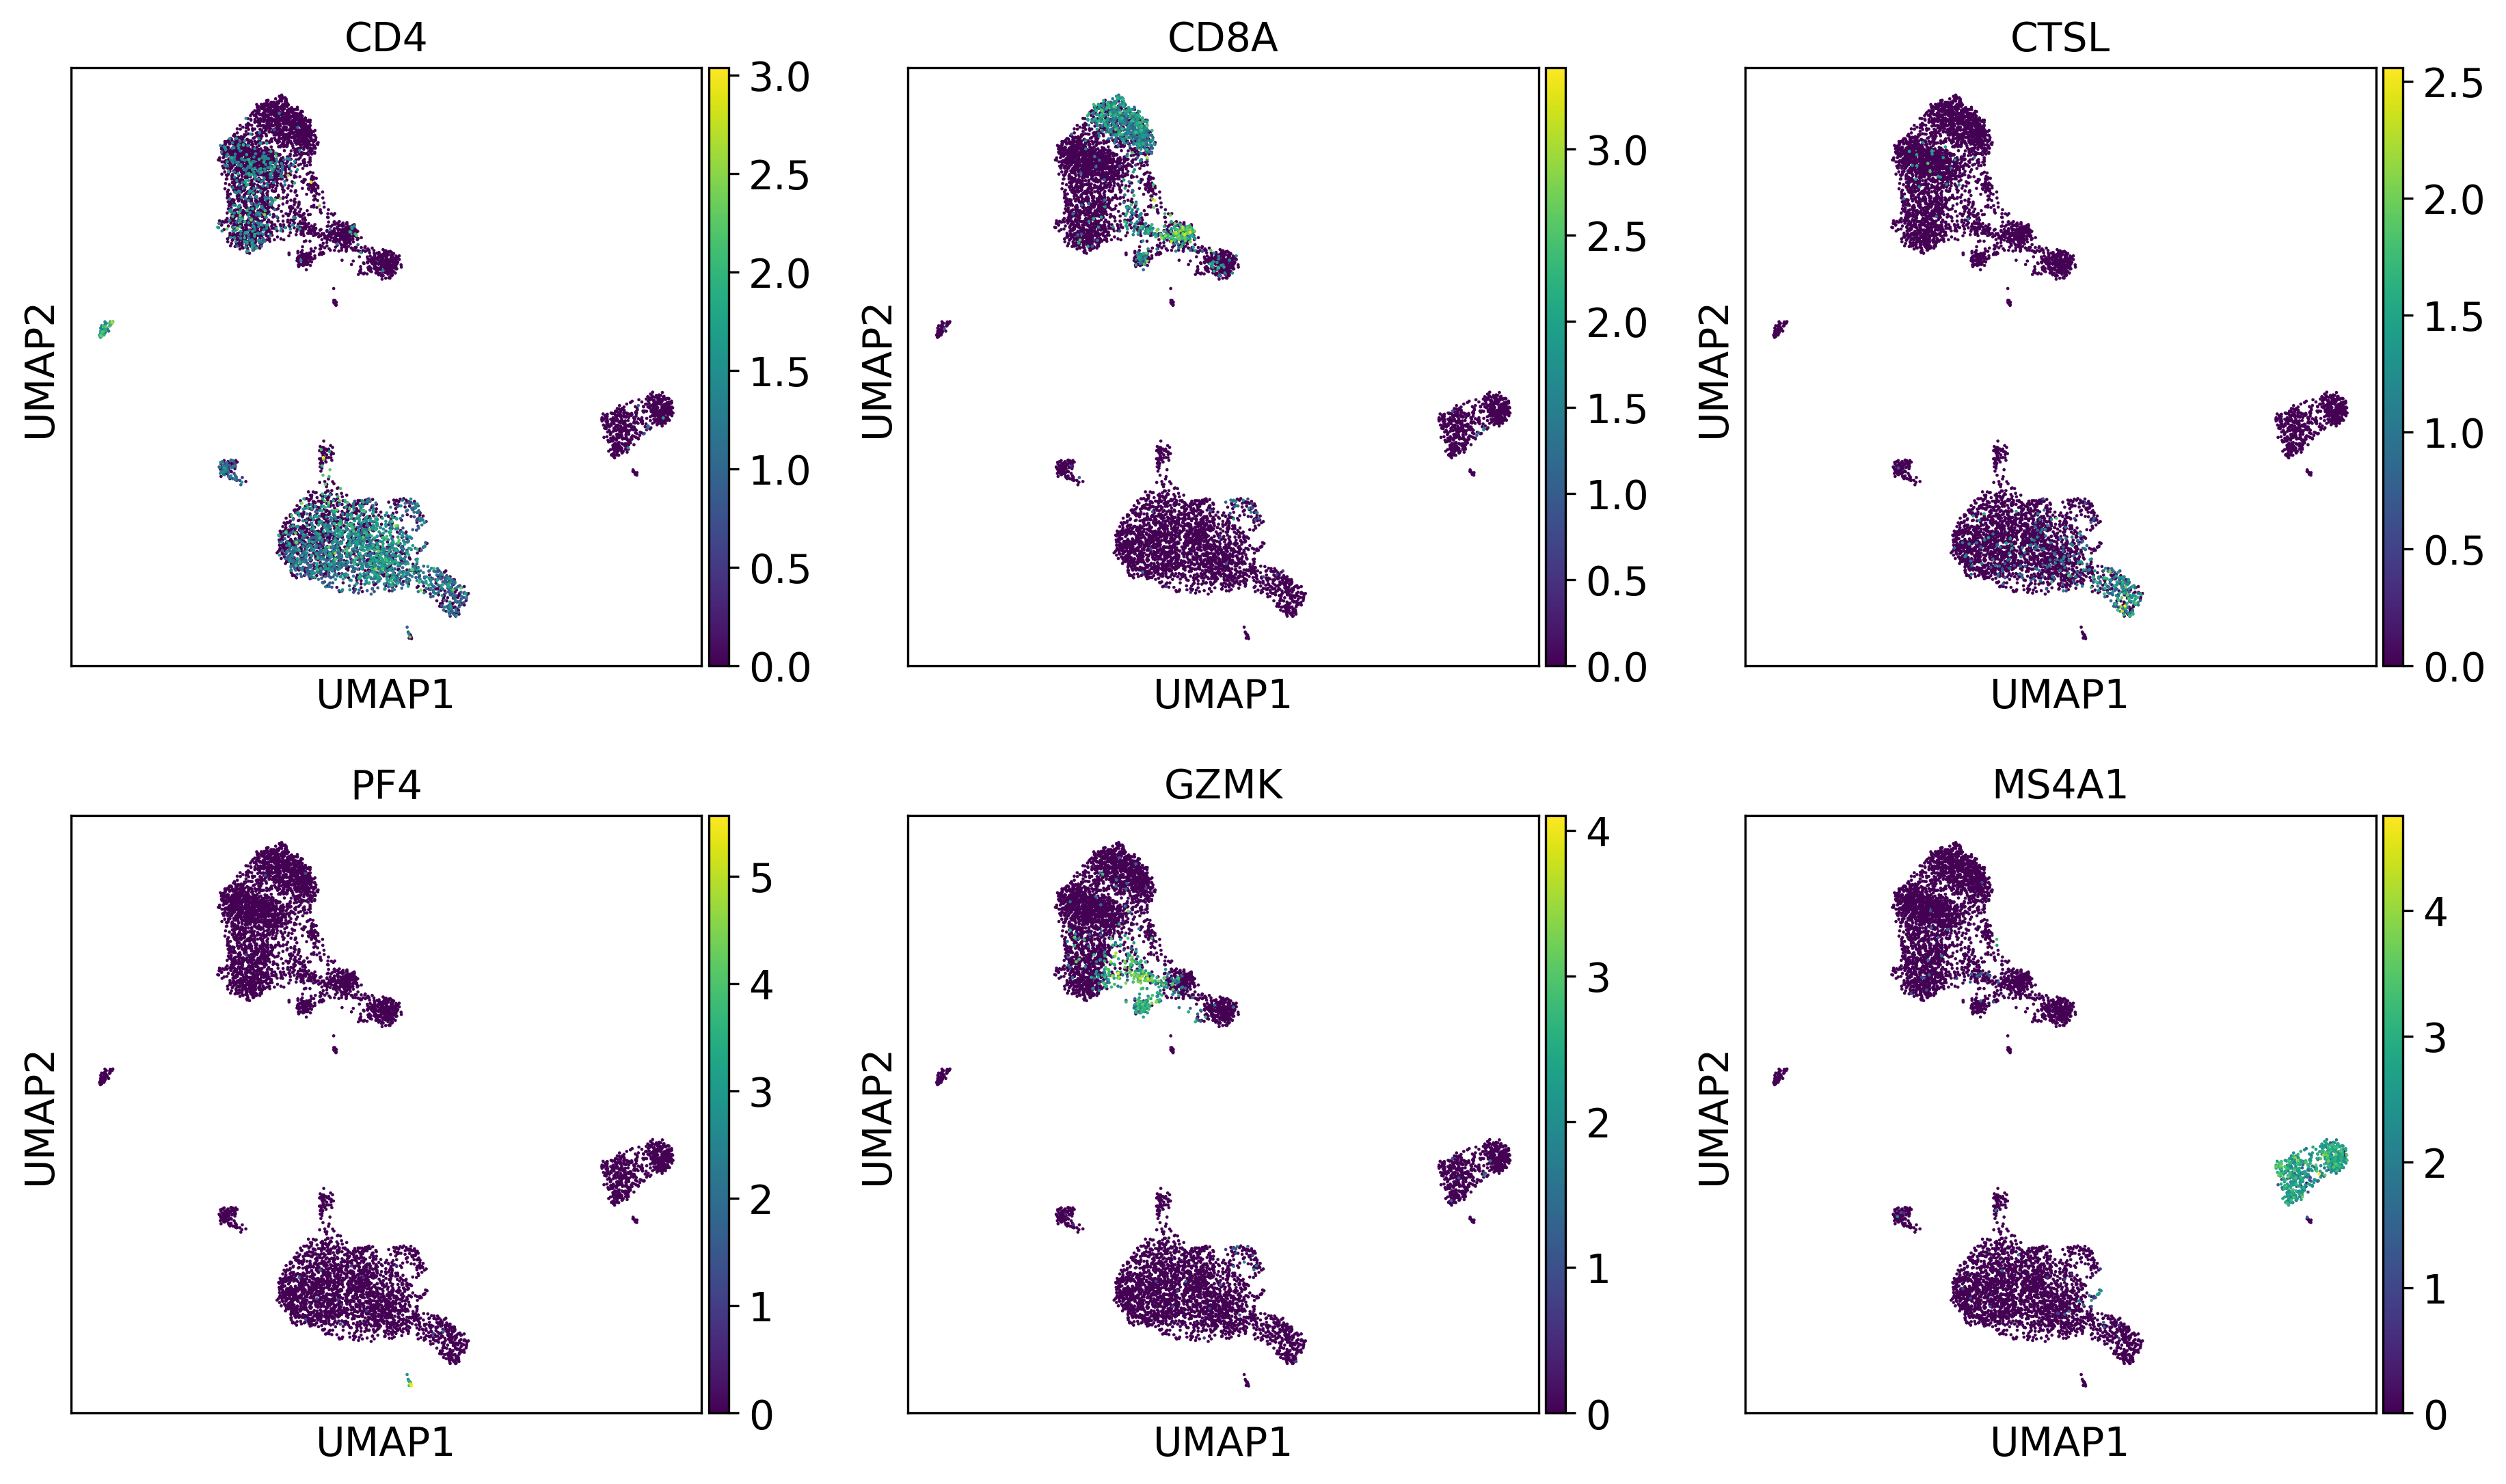

In [33]:
sc.pl.embedding(adata, basis='umap', color=['CD4', 'CD8A', 'CTSL', 'PF4', 'GZMK', 'MS4A1'], size=5, ncols=3)

### Topological analysis with TopOMetry

In [22]:
adata.write_h5ad(results_file)
adata = sc.read_h5ad(results_file)
adata

... storing 'feature_types' as categorical
... storing 'genome' as categorical


AnnData object with n_obs × n_vars = 6424 × 3513
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
# Fit topological model
tg = tp.models.TopoGraph(n_jobs=10,
  		  plot_spectrum=True
  		  ).fit(adata.X)
dgraph, dtgraph = tg.transform()

# Rescale to 50 components
tg.MSDiffMap = tg.DiffBasis.rescale(n_eigs=50)

adata.obsm['X_db'] = tg.MSDiffMap

In [27]:
# Layout optimization
embdt, aux = tp.models.MAP(tg.MSDiffMap, dtgraph, n_epochs=500)

adata.obsm['X_db_dtMAP'] = embdt

Fuzzy layout optimization embedding in = 7.622555 (sec)
Fuzzy layout optimization embedding in = 10.283989 (sec)


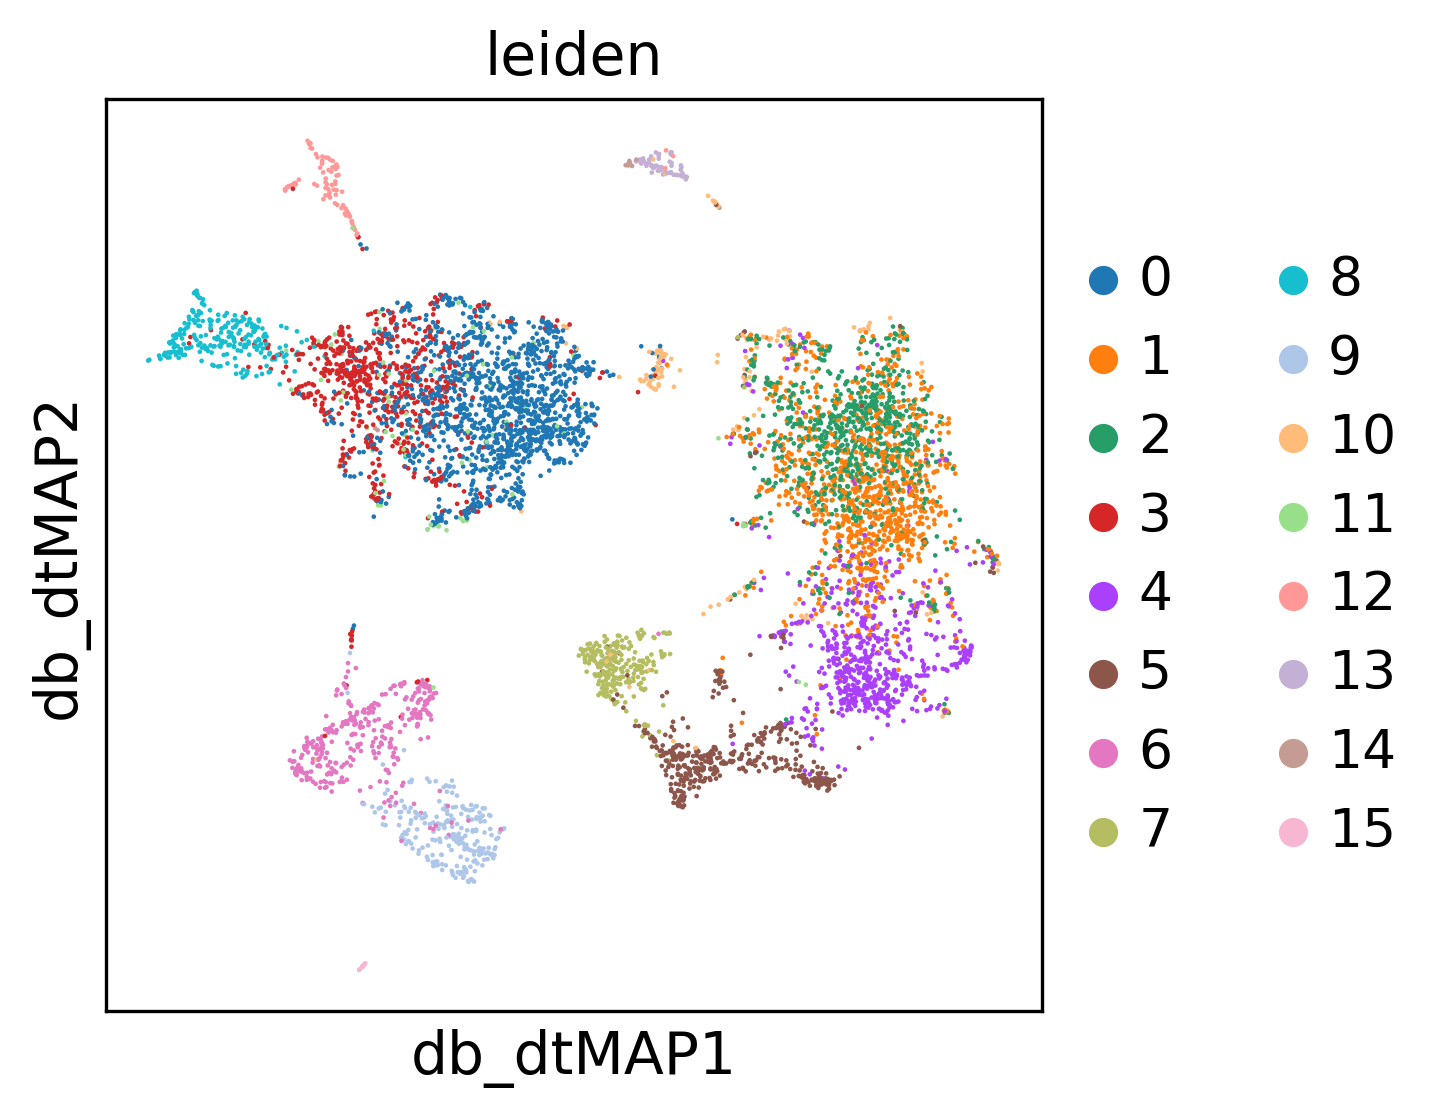

In [30]:
sc.pl.embedding(adata, basis='db_dtMAP', color=['leiden'], edges=False, size=5)

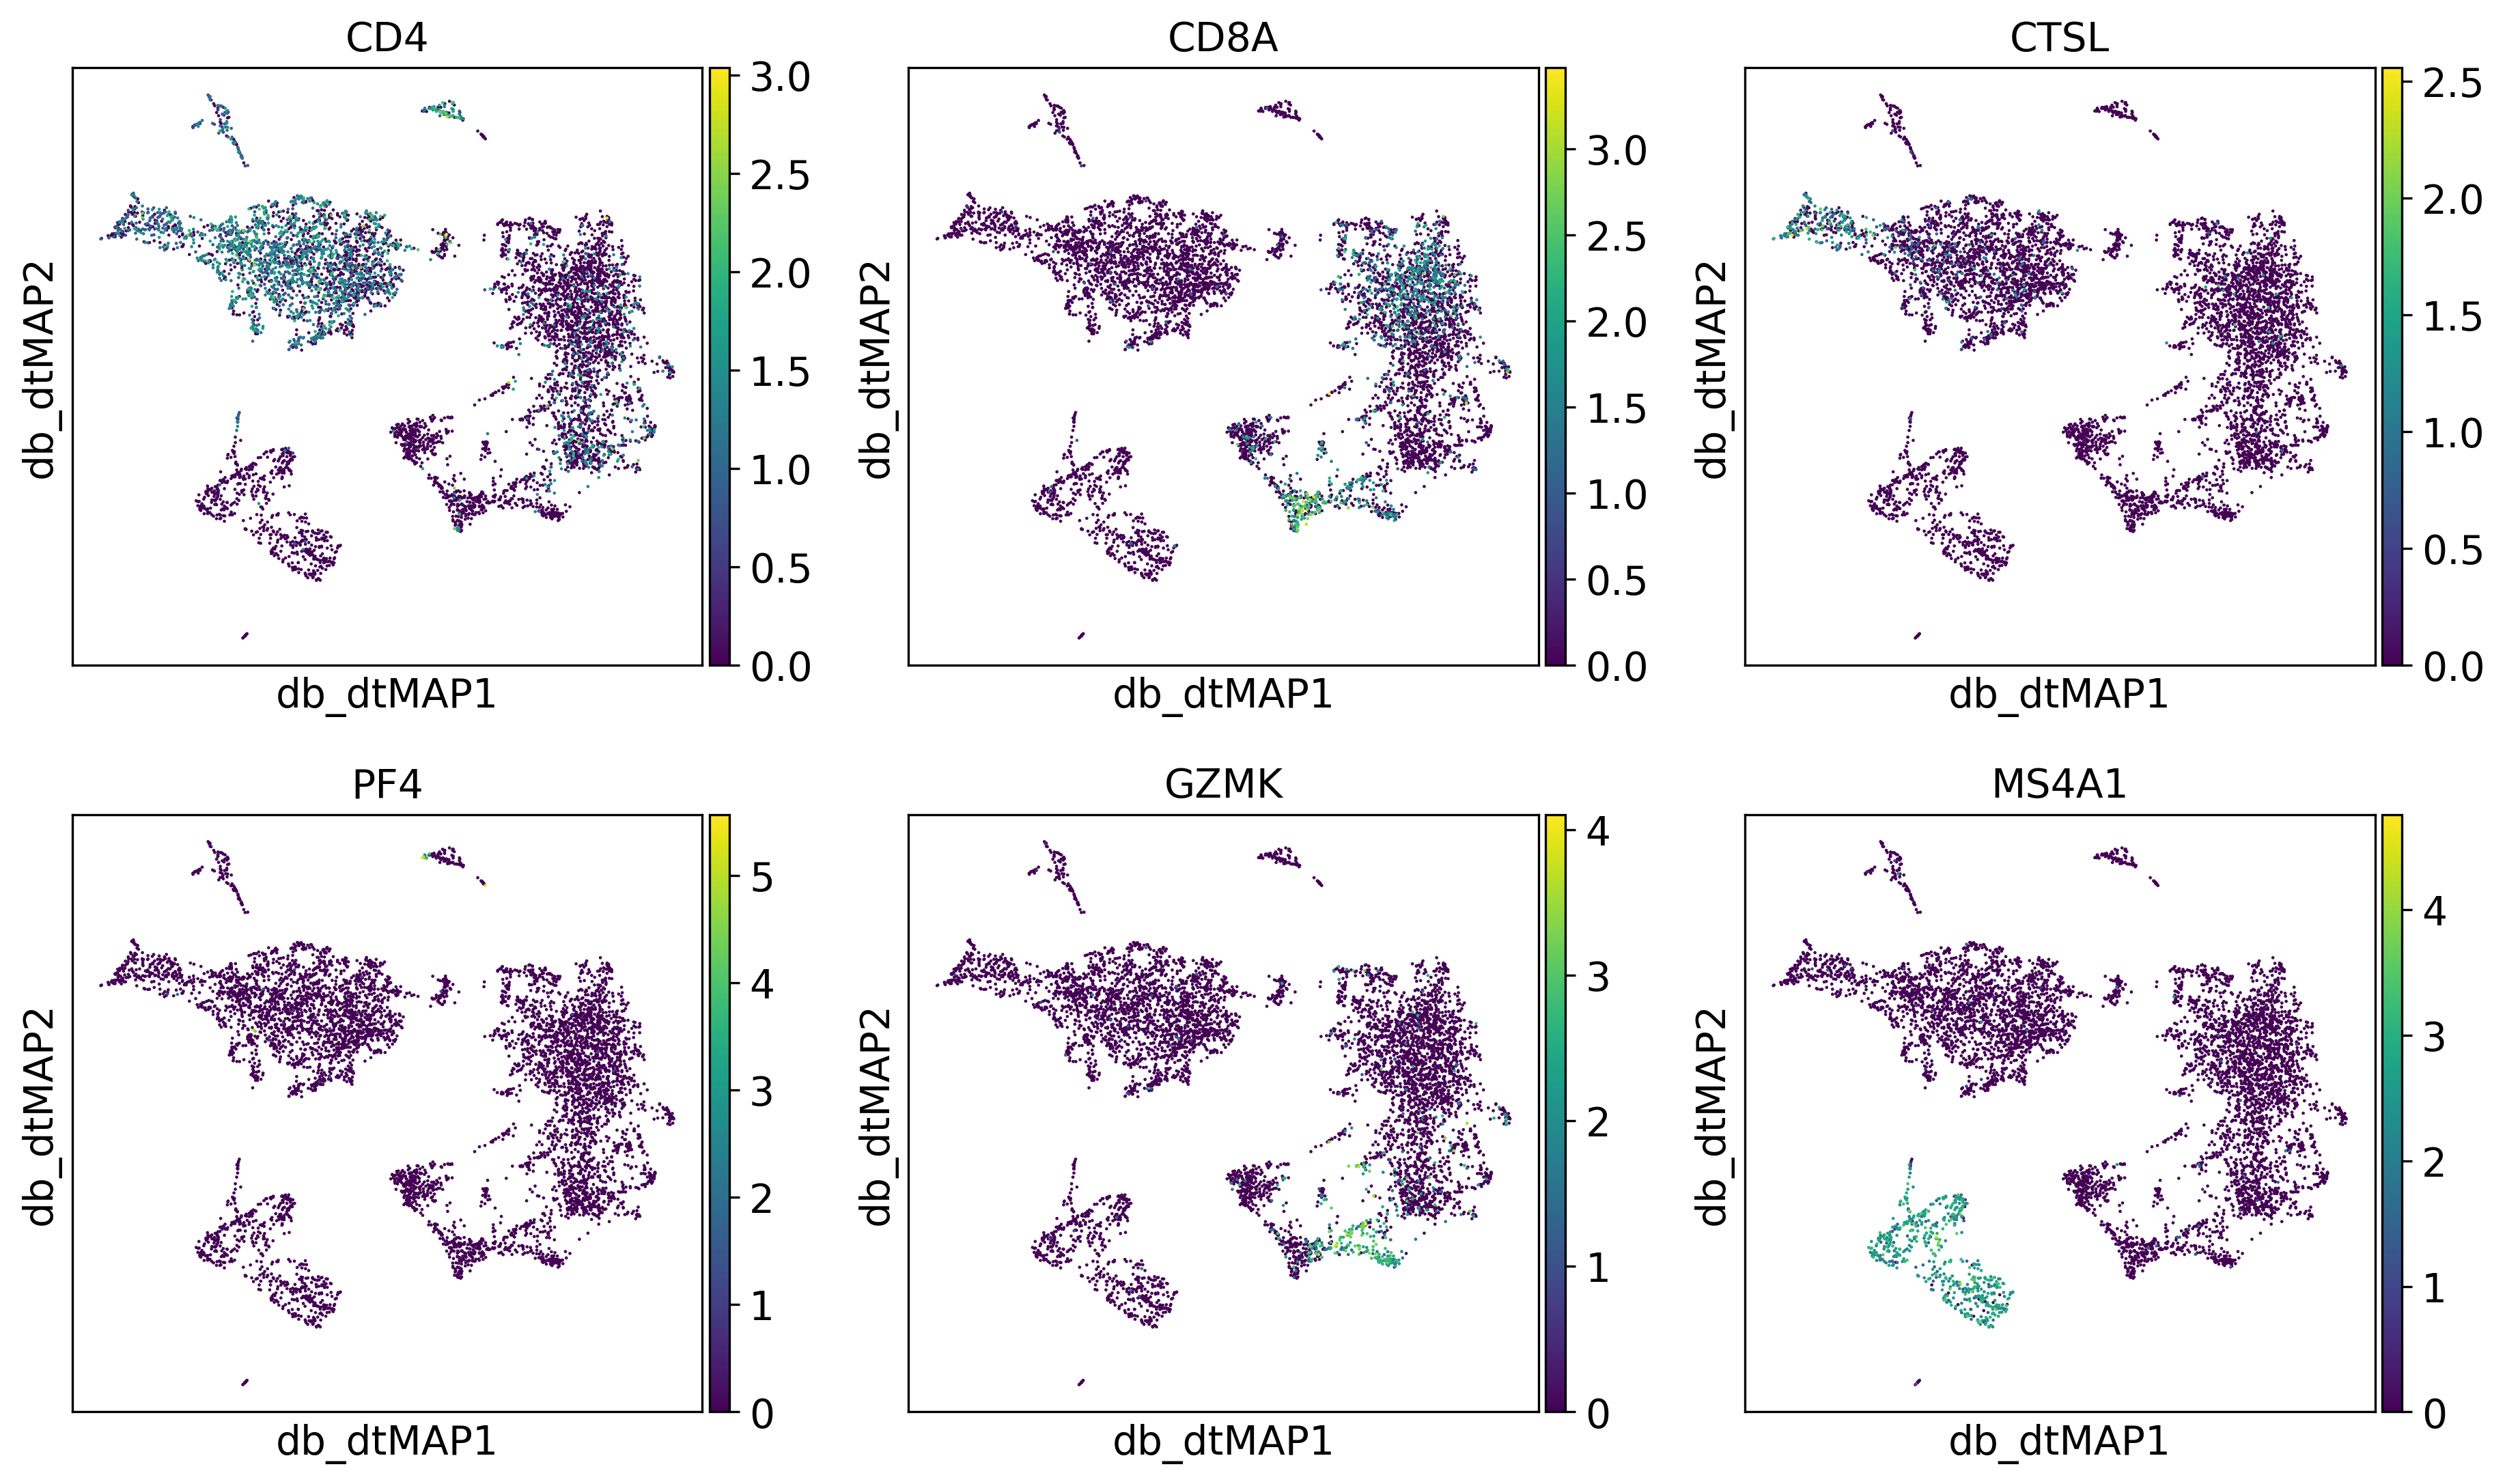

In [36]:
sc.pl.embedding(adata, basis='db_dtMAP', color=['CD4', 'CD8A', 'CTSL', 'PF4', 'GZMK', 'MS4A1'], size=5, ncols=3)